In [1]:
import numpy as np
from math import *
def conical_flow_calc(gamma, M1, shock_ang, del_theta):
  shock_ang = np.deg2rad(shock_ang)
  def_ang = atan(2*cot(shock_ang)*( ((M1**2)*(sin(shock_ang))**2 - 1)/ ((M1**2)*(gamma + cos(2*shock_ang))+ 2)))
  Mn1 = M1*sin(shock_ang)
  Mn2 = sqrt(( (gamma-1)*Mn1**2 + 2) / (2*gamma*Mn1**2 - (gamma-1) ))
  M2 = Mn2/(sin(shock_ang - def_ang))

  #  calc of downstream non dimensional components of radial and normal velocities
  non_dim_vel_initial = (2/((gamma-1)*(M2**2)) + 1)**(-0.5);
  non_dim_vel_r_initial = non_dim_vel_initial*cos(shock_ang - def_ang);
  non_dim_vel_theta_initial = -non_dim_vel_initial*sin(shock_ang - def_ang);

  # iterate to get cone angle
  down_param = [shock_ang, non_dim_vel_r_initial, non_dim_vel_theta_initial]
  count = 1
  while down_param[2] <0:
    theta = down_param[0] + del_theta
    down_param = rk4(theta, down_param[1], down_param[2], del_theta)
    count = count + 1
  
  # final paramters at cone surface
  cone_ang_in_deg = np.rad2deg(down_param[0])
  non_dim_vel_r_final = down_param[1]
  non_dim_vel_theta_final = down_param[2]
  non_dim_vel_final = sqrt(non_dim_vel_r_final**2 + non_dim_vel_theta_final**2)
  
  #Mc = np.sqrt(2/((gamma-1)*(non_dim_vel_r_final**(-2) - 1))) # considered only radial comp as tangential iterated to 0 but not actually 0, might lead to error later
  Mc = np.sqrt(2/((gamma-1)*(non_dim_vel_final**(-2) - 1)))

  pc_by_p1 = p_by_p0_isent(gamma, Mc) * (oblique_shock_calc(gamma, M1, shock_ang)[2]) * (p_by_p0_isent(gamma, M1))**(-1)

  return np.array([cone_ang_in_deg, non_dim_vel_r_final, non_dim_vel_theta_final, non_dim_vel_final, Mc, pc_by_p1])

def cot(x):
  return 1.0/np.tan(x)

def f(x,y,z):
  return z

G = 1.4

def g(x,y,z): 
  c = (G - 1)/2
  nr = c*(1-y**2-z**2)*(2*y + z*cot(x)) - y*z**2
  dr = c*(y**2 + z**2 - 1) + z**2
  return nr/dr

def rk4(x0, y0, z0, h): 
  k1 = h * (f(x0, y0, z0))
  l1 = h * (g(x0, y0, z0))
  k2 = h * (f((x0+h/2), (y0+k1/2), (z0 + l1/2)))
  l2 = h * (g((x0+h/2), (y0+k1/2), (z0 + l1/2)))
  k3 = h * (f((x0+h/2), (y0+k2/2), (z0 + l2/2)))
  l3 = h * (g((x0+h/2), (y0+k2/2), (z0 + l2/2)))
  k4 = h * (f((x0+h), (y0+k3), (z0 + l3))) 
  l4 = h * (g((x0+h), (y0+k3), (z0 + l3))) 
  y1 = y0 + (k1 + 2*k2 + 2*k3 + k4)/6
  z1 = z0 + (l1 + 2*l2 + 2*l3 + l4)/6
  rk4_conical = [x0, y1, z1]
  return rk4_conical

In [2]:
def p_by_p0_isent(gamma, M):
  p_by_p0 = (1 + ((gamma - 1)/2)*M**2)**(-gamma/(gamma-1))
  return p_by_p0

def normal_shock_calc(gamma, M):
  M2 = sqrt(( (gamma-1)*M**2 + 2) / (2*gamma*M**2 - (gamma-1) ))
  p2_by_p1 = (2*gamma*M**2)/(gamma + 1) - (gamma - 1)/(gamma + 1)
  p02_by_p01 = (p_by_p0_isent(gamma, M2))**(-1)*p2_by_p1*p_by_p0_isent(gamma, M)
  return [M2, p2_by_p1, p02_by_p01]

def oblique_shock_calc(gamma, M, shock_ang):
  Mn1 = M*np.sin(shock_ang)
  return normal_shock_calc(gamma, Mn1)

def cone_shock_calc(gamma, Mc, M1, shock_ang):
  shock_ang = np.deg2rad(shock_ang)
  pc_by_p1 = (1 + ((gamma - 1)/2)*Mc**2)**(-gamma/(gamma-1)) * ( ( (((gamma + 1)/2)*(M1*np.sin(shock_ang))**2) / (1 + ((gamma - 1)/2)*(M1*np.sin(shock_ang))**2) )**(gamma/(gamma - 1)) ) * ( (2*gamma*(M1*np.sin(shock_ang))**2)/(gamma + 1) - (gamma - 1)/(gamma + 1) )**(-1/(gamma - 1)) * ((1 + ((gamma - 1)/2)*M1**2)**(-gamma/(gamma-1)))**(-1)
  return pc_by_p1


In [3]:
def conical_shock_polar(gamma, M):
  from numpy.core.fromnumeric import size
  import matplotlib.pyplot as plt
  shock_ang_min = asin(1/M)*180/pi + 5e-2 # gives correct results after 1e-1 only
  shock_ang_range = np.linspace(shock_ang_min, 90 - 5e-2, num = 10000)
  pc_by_p1_range = np.zeros(size(shock_ang_range))
  cone_ang_range = np.zeros(size(shock_ang_range))

  # print(shock_ang_range)
  # print(conical_sp(1.4, 2, 89.95, -1e-3))

  for i in range(size(shock_ang_range)):
    cone_ang_range[i] = conical_flow_calc(gamma, M, shock_ang_range[i], -1e-3)[0]
    pc_by_p1_range[i] = cone_shock_calc(gamma, conical_flow_calc(gamma, M, shock_ang_range[i], -1e-3)[4], M, shock_ang_range[i])
  print(cone_ang_range)
  print(pc_by_p1_range) 

  cone_ang_range = np.insert(cone_ang_range, 0, 0)
  pc_by_p1_range = np.insert(pc_by_p1_range, 0, 1)
  cone_ang_range = np.append(cone_ang_range, 0)
  pc_by_p1_range = np.append(pc_by_p1_range, normal_shock_calc(gamma, M)[1] )

  print(cone_ang_range[0], pc_by_p1_range[0], cone_ang_range[-1], pc_by_p1_range[-1])
  plt.plot(cone_ang_range, pc_by_p1_range, 'b-', -cone_ang_range, pc_by_p1_range, 'b-')
  plt.xlabel('Half-cone angle (in deg)')
  plt.ylabel('Pressure ratio (Pc/P1)')
  plt.show


[1.57399758 2.32483331 2.78919015 ... 1.81710991 1.59391739 1.37072487]
[1.01700602 1.02934587 1.03838014 ... 4.50793043 4.50640939 4.50482547]
0.0 1.0 0.0 4.5
Duration: 0:06:09.063991


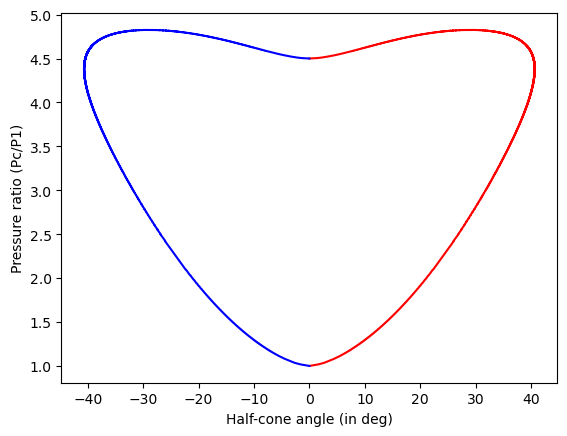

In [4]:
conical_shock_polar(1.4, 2)